# <span style ='color:orange'>Imports

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import shap

%reload_ext autoreload
%autoreload 2

from data_boxscore.data import load_dataframes, custom_query_df
from data_boxscore.xai import shap_query
from data_boxscore.constants import  features_minmax, features_no_scaling, features_perc, features_robust, features_standard
from data_boxscore.plots import create_spider_chart

# <span style ='color:blue'>Loading data

In [84]:
team = "Valencia Basket Club"
league = None
season = None

excl_feat = ['score', 'score', 'FGM', 'FGM',
       'FGA', 'FGA', 'FG%', 'FG%', '2FGM', '2FGM', '2FGA',
       '2FGA', '2FG%', '2FG%', '3FGM', '3FGM', '3FGA', '3FGA',
       '3FG%', '3FG%', 'FTM', 'FTM', 'FTA', 'FTA', 'FT%',
       'FT%', 'OREB', 'OREB', 'DREB', 'DREB', 'TREB', 'TREB',
       'AST', 'AST', 'PF', 'PF', 'TO', 'TO', 'ST', 'ST',
       'BLF', 'BLF', 'plus-minus', 'plus-minus', 'efficiency',
       'efficiency', 'diff_score', 'ELO_diff_before']
excl_cols = ['home_'+feat for feat in excl_feat] + ['away_'+feat for feat in excl_feat] + ['diff_score','ELO_diff_before']

In [85]:
gdf, X_train, y_train, X_val, y_val, X_test, y_test, X_query, y_query = load_dataframes(filename='bball.csv',
                                                                    features_standard = features_standard, 
                                                                    features_minmax = features_minmax, 
                                                                    features_robust = features_robust, 
                                                                    features_perc = features_perc,
                                                                    features_no_scaling = features_no_scaling,              
                                                                    use_ELO = True,
                                                                    k_elo = 20,
                                                                    excluded_columns=excl_cols,
                                                                    team=team,
                                                                    season=season,
                                                                    league=league)
print(gdf.shape, X_train.shape, X_val.shape ,X_test.shape, )
gdf['home_win'].mean()

(840, 58) (504, 6) (126, 6) (126, 6)


0.6

In [86]:
gdf.head(5)

,away_team,home_team,away_score,home_score,away_FGM,home_FGM,away_FGA,home_FGA,away_FG%,home_FG%,...,home_eFG%,away_eFG%,home_OREB%,away_OREB%,home_TOV%,away_TOV%,diff_score,home_win,ELO_diff_before,split
game_id,,,,,,,,,,,,,,,,,,,,,
0,CCC Polkowice,Pieštanské Cajky,71,46,24,14,54,49,0.444444,0.285714,...,0.326531,0.509259,0.216216,0.264706,0.236097,0.201918,-25,False,0.0,0
1,Pieštanské Cajky,CCC Polkowice,60,76,24,27,65,53,0.369231,0.509434,...,0.584906,0.407692,0.230769,0.300000,0.230651,0.180549,16,True,20.0,0
2,BLMA,KSC Szekszard,79,80,29,28,48,59,0.604167,0.474576,...,0.550847,0.625000,0.382353,0.363636,0.199437,0.227638,1,True,0.0,0
3,KSC Szekszard,BLMA,71,86,26,30,58,56,0.448276,0.535714,...,0.598214,0.534483,0.400000,0.322581,0.234632,0.242718,15,True,-20.0,0
4,Galatasaray,Sopron Basket,55,72,23,29,71,58,0.323944,0.500000,...,0.517241,0.345070,0.357143,0.224490,0.270880,0.165125,17,True,0.0,0


In [87]:
X_test = X_test[:10]
y_test = y_test[:10]
X_test.shape, y_test.shape

((10, 6), (10,))

# <span style ='color:green'>Models

In [88]:
from sklearn.svm import SVC

model = SVC(kernel = 'rbf', probability=True, C = 50, gamma = 0.0005)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Model accuracy = {accuracy_score(y_pred, y_test)}")

Model accuracy = 0.8


# <span style ='color:lightgreen'>XAI

### Local

In [89]:
# creating SV object with all X_train in the background
shap_prob_explainer = shap.Explainer(model.predict_proba, X_train)
# Fitting on X_test
sv_prob = shap_prob_explainer(X_test)

Index max in test set : 10


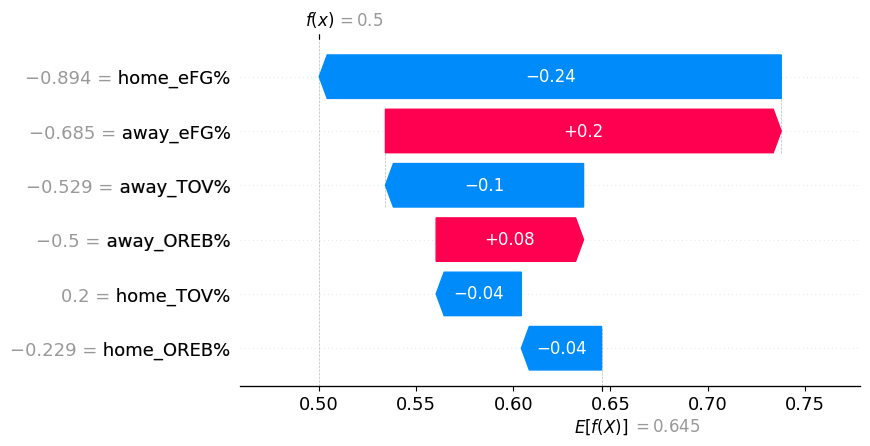

In [90]:
ind = 9

print(f"Index max in test set : {X_test.shape[0]}")
shap.plots.waterfall(sv_prob[ind,:,1])

### Global

In [91]:
# creating SV object with all X_train in the background
shap_pred_explainer = shap.Explainer(model.predict, X_train)
# Fitting on X_test
sv_pred = shap_pred_explainer(X_test)

<Axes: xlabel='SHAP value (impact on model output)'>

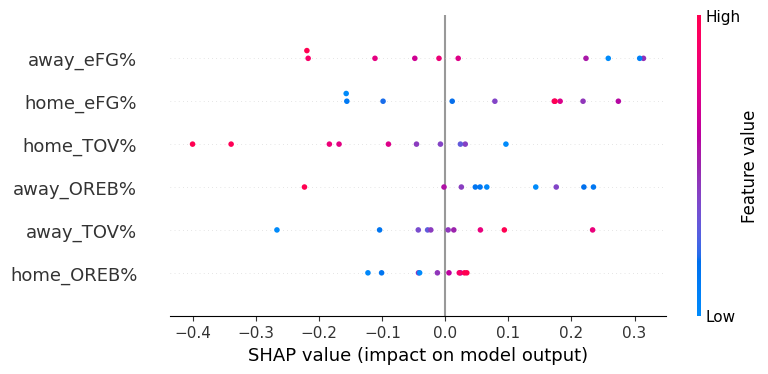

In [92]:
shap.plots.beeswarm(sv_pred, max_display=13, show=False)

### Query

In [93]:
X_query.shape

(31, 6)

In [94]:
shap_query_df = shap_query(df =gdf,
                           X_query = X_query,
                           shap_explainer= shap_prob_explainer,
                           team=team,
                           season = season,
                           league = league)
shap_query_df.head()

,home_team,away_team,team_eFG%,opponent_eFG%,team_OREB%,opponent_OREB%,team_TOV%,opponent_TOV%
0,Valencia Basket Club,Virtus Segafredo Bologna,-0.111463,-0.379718,-0.099178,-0.091064,0.255268,0.193617
1,Valencia Basket Club,ZVVZ USK Praha,0.036681,-0.207600,-0.114799,-0.022511,-0.203153,-0.115416
2,Valencia Basket Club,Atomeromu KSC Szekszard,0.245166,0.169559,-0.055284,0.039720,-0.048341,0.000829
3,Valencia Basket Club,Tango Bourges Basket,0.199003,0.202285,-0.000550,-0.000584,-0.065859,0.012604
4,BC Polkowice,Valencia Basket Club,-0.076222,-0.197066,-0.123200,-0.042228,0.187955,-0.008766


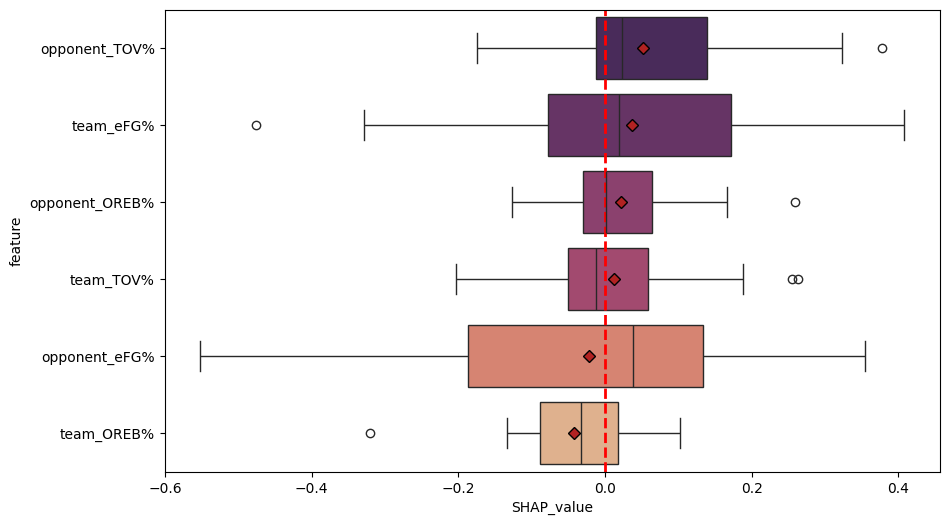

In [95]:
threshold = 0.0001

fig, ax = plt.subplots(1,1,figsize = (10,6))
info_cols = ['game_id','home_team', 'away_team'] if 'game_id' in shap_query_df.columns else ['home_team', 'away_team']
team_expl_cols = shap_query_df.drop(columns = info_cols).columns
id = pd.MultiIndex.from_product([shap_query_df[team_expl_cols].index, shap_query_df[team_expl_cols].columns], names=('gameday', 'feature'))
t_df = pd.DataFrame(np.array(shap_query_df[team_expl_cols]).reshape(len(shap_query_df[team_expl_cols])*len(shap_query_df[team_expl_cols].columns),1), index = id).rename(columns={0:'SHAP_value'})
t_df.reset_index(inplace= True)
feat_mask = (t_df.groupby('feature').mean()['SHAP_value'].abs() > threshold).rename('Threshold_filter')
mean_shap = t_df.groupby('feature').mean()['SHAP_value'].rename('Mean_SHAP_value')
t_df = t_df.merge(feat_mask, left_on = 'feature', right_index = True)
t_df = t_df.merge(mean_shap, left_on = 'feature', right_index = True)
t_df.sort_values(by = 'Mean_SHAP_value', ascending = False, inplace=True)
meanpointprops = dict(marker='D', markeredgecolor='black',
                    markerfacecolor='firebrick')
sns.boxplot(data = t_df[t_df['Threshold_filter']], x = 'SHAP_value', y = 'feature', hue = 'Mean_SHAP_value', palette = 'flare', legend = False, ax=ax, showmeans = True, meanprops = meanpointprops)
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
plt.show()
plt.close()

In [96]:
spider_plot_df = t_df[['feature','SHAP_value']].groupby('feature').mean()
spider_plot_df = spider_plot_df.merge(t_df[['feature','SHAP_value']].groupby('feature').std().rename(columns = {'SHAP_value':'std'}), right_index=True, left_index= True)
spider_plot_df

,SHAP_value,std
feature,,
opponent_OREB%,0.021819,0.088042
opponent_TOV%,0.052191,0.138817
opponent_eFG%,-0.021372,0.217535
team_OREB%,-0.042361,0.079919
team_TOV%,0.011756,0.105703
team_eFG%,0.037418,0.209330


In [106]:
max_val = (spider_plot_df['SHAP_value'].max()*100 //2 +1)/50
min_val = (spider_plot_df['SHAP_value'].min()*100 //2)/50
graduation_level = int(max_val*50) -int(min_val*50)

min_val, max_val, graduation_level


(-0.06, 0.06, 6)

In [110]:
min_val // 1000, max_val//1000, (2* max_val) // 1000

(-1.0, 0.0, 0.0)

In [147]:
def plot_scaler(values:np.array):
    min_val = values.min()
    max_val = values.max()
    sign_diff = max_val * min_val <0
    scale = 1000
    while max_val // scale - min_val // scale - int(sign_diff) == 0 :
        scale = scale / 10
    lower_bound = min_val // scale
    upper_bond = max_val // scale +1
    nb_bins = upper_bond - lower_bound
    i = 1
    while nb_bins // i > 10 :
        i+=1
    step_size = int(nb_bins // (nb_bins // i)) 
    if sign_diff :
        lower_bound = lower_bound// step_size * step_size
        upper_bond = (upper_bond // step_size) *step_size 
    nb_graduations = (upper_bond - lower_bound) // step_size
    return int(nb_graduations), lower_bound*scale, upper_bond*scale

In [151]:
values_to_scale = np.concatenate((spider_plot_df['SHAP_value'] + spider_plot_df['std'],
                                  spider_plot_df['SHAP_value'] - spider_plot_df['std']))
values_to_scale

array([ 0.10986154,  0.1910086 ,  0.19616321,  0.03755847,  0.11745885,
        0.24674804, -0.06622284, -0.08662619, -0.23890685, -0.12227987,
       -0.0939466 , -0.17191235])

In [152]:
graduation_level, min_val, max_val = plot_scaler(values_to_scale)
graduation_level, min_val, max_val

(6, -0.30000000000000004, 0.30000000000000004)

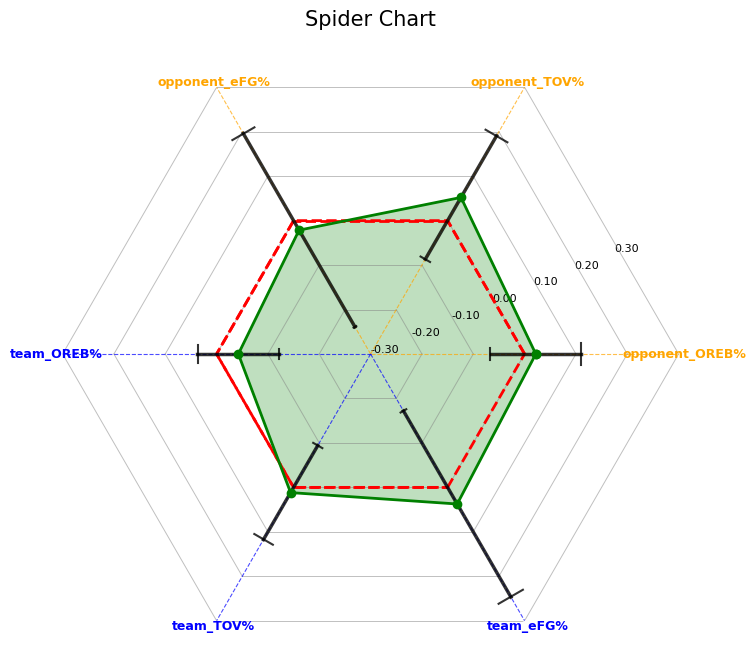

In [197]:
create_spider_chart(
    categories=spider_plot_df.index,
    values=spider_plot_df['SHAP_value'],
    color = 'green',
    std_devs=spider_plot_df['std'],
    min_value=min_val,
    max_value=max_val,
    graduation_levels=graduation_level,
    highlight_level=0,
    category_colors=['blue' if feat[:4] == 'team' else 'orange' for feat in spider_plot_df.index]
);